# CDAW CME Catalog Creation Notebook
This notebook is for parsing the online version and creating a CDAW CME catalog we may use. Changes include: we'll calculate duration of events in C2, C3 detectors and write as CSV.

Some very light analysis of calculated durations is conducted near the end of the notebook.

In [1]:
import requests
import pandas as pd

Need_To_Redownload = False
CDAW_Catalog_Filename = '../cdaw_catalog.txt'
# LASCO_Catalog_Filename = '../lasco_img_catalog_lvl_1.txt'
CME_Catalog_Filename = '../cme_event_catalog.csv'
Full_CME_Catalog_Filename = '../full_cme_event_catalog.csv'

In [2]:
# pull the cme catalog to local disk
if Need_To_Redownload:
    
    cme_catalog_url = 'https://cdaw.gsfc.nasa.gov/CME_list/UNIVERSAL/text_ver/univ_all.txt'
    response = requests.get(cme_catalog_url, allow_redirects=True)
    
    # cache locally
    open(CDAW_Catalog_Filename, 'wb').write(response.content)

    # parse out data into string lines from byte block
    cdaw_raw_lines = response.content.decode('utf-8').split('\n')
    
    # download LASCO catalog now
    #lasco_hdr_url = 'https://lasco-www.nrl.navy.mil/lz/img_hdr.txt'   # level 0.5 data
    #lasco_hdr_url = 'https://lasco-www.nrl.navy.mil/lz/level_1/img_hdr.txt'
    #response = requests.get(lasco_hdr_url, allow_redirects=True)
    
    # cache locally
    # open(LASCO_Catalog_Filename, 'wb').write(response.content)

else:
    
    with open(CDAW_Catalog_Filename, 'r') as f:
        cdaw_raw_lines = f.readlines()
        
    print(f"Read %s CDAW lines" % len(cdaw_raw_lines))
        

Read 30489 CDAW lines


In [3]:
#snag field names from top of file. Its not entirely correct, 
# but 'good enough' for now
fields = cdaw_raw_lines[1].split()
fields

['Date',
 'Time',
 'Central',
 'Width',
 'Linear',
 '2nd',
 'order',
 'speed',
 'Accel',
 'Mass',
 'Kinetic',
 'MPA',
 'Remarks']

In [4]:
# parse remainder of lines into dataframe using regex pattern
# only date and time fields appear to be consistently same format,
# we have to guard against non-numbers in all of the other columns
import re

pattern_str = r"^(\d{4}/\d{2}/\d{2})\s+(\d{2}:\d{2}:\d{2})\s+(\S+)\s+(\S+)\s+(\S+)\s+" +\
              r"(\S+)\s+(\S+)\s+(\S+)\s+(\S+?)\s+(\S+)\s+(\S+)\s+(\S+)\s+(\S[\S|\s]+)?$"
pattern = re.compile(pattern_str)

data_arr = { fld:[] for fld in fields }
# parse remainder into columns
for line in cdaw_raw_lines[4:]:
    m = pattern.match(line)
    if m:
        for grp in range(1,len(m.groups())+1): 
            #print(f"{grp}: %s" % m.group(grp))
            data_arr[fields[grp-1]].append(m.group(grp))
    else:
        print (f"Warning: cannot parse line:\n  {line}")
        
raw_data = pd.DataFrame(data_arr)
raw_data

,Date,Time,Central,Width,Linear,2nd,order,speed,Accel,Mass,Kinetic,MPA,Remarks
0,1996/01/11,00:14:36,267,18,499,571,426,0,-64.3*,-------,-------,272,Only C3\n
1,1996/01/13,22:08:30,265,16,290,278,303,372,2.8*,-------,-------,266,Only C3\n
2,1996/01/15,07:01:10,262,43,525,600,454,0,-31.1,-------,-------,272,Only C3\n
3,1996/01/22,03:11:01,105,37,267,401,130,0,-126.3*,7.1e+13*,2.5e+28*,103,Very Poor Event; Only C3\n
4,1996/01/26,09:16:19,90,27,262,254,271,322,1.9*,3.0e+14,1.0e+29,90,Poor Event; Only C3\n
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30480,2020/08/29,15:36:05,284,11,196,227,163,0,-4.8*,-------,-------,282,Poor Event\n
30481,2020/08/29,19:48:05,285,10,218,231,204,79,-2.0*,-------,-------,272,Poor Event\n
30482,2020/08/30,01:25:44,258,42,117,0,213,286,3.5*,-------,-------,250,Poor Event\n
30483,2020/08/31,02:12:05,74,53,213,244,182,0,-5.2*,-------,-------,82,Poor Event\n


In [5]:
# filter out data, accelerations with "*" or "------"
# are either unreliable (too few measurements) or no measurement could be made

#filtered = raw_data[raw_data['Accel']!='------']
#filtered = filtered[filtered.Accel.str.contains('\*') == False]
#filtered

In [6]:
# Data Cleaning: filter out Bad/Poor data: Missing Linear speed ('------') and
# 'Very Poor Event' and 'None' in Remarks
# 
cleaned = raw_data[raw_data['Linear'] != '----']
#cleaned = cleaned[cleaned.Remarks.str.contains('Very Poor Event') == False]
cleaned = cleaned[cleaned.Remarks.str.contains('None') == False]
cleaned

,Date,Time,Central,Width,Linear,2nd,order,speed,Accel,Mass,Kinetic,MPA,Remarks
0,1996/01/11,00:14:36,267,18,499,571,426,0,-64.3*,-------,-------,272,Only C3\n
1,1996/01/13,22:08:30,265,16,290,278,303,372,2.8*,-------,-------,266,Only C3\n
2,1996/01/15,07:01:10,262,43,525,600,454,0,-31.1,-------,-------,272,Only C3\n
3,1996/01/22,03:11:01,105,37,267,401,130,0,-126.3*,7.1e+13*,2.5e+28*,103,Very Poor Event; Only C3\n
4,1996/01/26,09:16:19,90,27,262,254,271,322,1.9*,3.0e+14,1.0e+29,90,Poor Event; Only C3\n
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30480,2020/08/29,15:36:05,284,11,196,227,163,0,-4.8*,-------,-------,282,Poor Event\n
30481,2020/08/29,19:48:05,285,10,218,231,204,79,-2.0*,-------,-------,272,Poor Event\n
30482,2020/08/30,01:25:44,258,42,117,0,213,286,3.5*,-------,-------,250,Poor Event\n
30483,2020/08/31,02:12:05,74,53,213,244,182,0,-5.2*,-------,-------,82,Poor Event\n


## calculate durations for each detector (C2 1.5 - 6 Rsol and C3 is 3.7 - 30 Rsol)

#### T_c2_start == catalog time_start

Our formula for duration:
  700,000 * Det_max_Rsol /linear speed = T_duration_det

#### C2 Duration : 4200000 / speed = T_c2
 
C3 Start time delta (from C2) is C2_Start + (3.7 - 1.5) * R_sol
or
2.2 * R_sol  = T_c3_start_delta

#### C3 Delta Start is 1540000 + T_c2_start

C3 duration is (30 - 3.7) * R_sol / linear speed

#### C3 Duration: 18410000 / speed = T_c3




In [7]:
c2_durations = [ 4200000./int(speed) for speed in cleaned['Linear']]
c3_durations = [ 18410000./int(speed) for speed in cleaned['Linear']]
# delta is C3 start time (est) after event start (at Sun).
c3_start_delta = [1540000./int(speed) for speed in cleaned['Linear']]

In [8]:
data = cleaned
data['Duration_C2'] = c2_durations
data['Duration_C3'] = c3_durations
data['StartTime_C3_Delta'] = c3_start_delta

In [9]:
data

,Date,Time,Central,Width,Linear,2nd,order,speed,Accel,Mass,Kinetic,MPA,Remarks,Duration_C2,Duration_C3,StartTime_C3_Delta
0,1996/01/11,00:14:36,267,18,499,571,426,0,-64.3*,-------,-------,272,Only C3\n,8416.833667,36893.787575,3086.172345
1,1996/01/13,22:08:30,265,16,290,278,303,372,2.8*,-------,-------,266,Only C3\n,14482.758621,63482.758621,5310.344828
2,1996/01/15,07:01:10,262,43,525,600,454,0,-31.1,-------,-------,272,Only C3\n,8000.000000,35066.666667,2933.333333
3,1996/01/22,03:11:01,105,37,267,401,130,0,-126.3*,7.1e+13*,2.5e+28*,103,Very Poor Event; Only C3\n,15730.337079,68951.310861,5767.790262
4,1996/01/26,09:16:19,90,27,262,254,271,322,1.9*,3.0e+14,1.0e+29,90,Poor Event; Only C3\n,16030.534351,70267.175573,5877.862595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30480,2020/08/29,15:36:05,284,11,196,227,163,0,-4.8*,-------,-------,282,Poor Event\n,21428.571429,93928.571429,7857.142857
30481,2020/08/29,19:48:05,285,10,218,231,204,79,-2.0*,-------,-------,272,Poor Event\n,19266.055046,84449.541284,7064.220183
30482,2020/08/30,01:25:44,258,42,117,0,213,286,3.5*,-------,-------,250,Poor Event\n,35897.435897,157350.427350,13162.393162
30483,2020/08/31,02:12:05,74,53,213,244,182,0,-5.2*,-------,-------,82,Poor Event\n,19718.309859,86431.924883,7230.046948


In [10]:
import numpy as np
import matplotlib.pyplot as plt
    
def plot_data (xdata, ydata, xlabel="", ylabel="", title="", alpha=1.0):

    fig, ax = plt.subplots()
    #plt.style.use('fivethirtyeight')
    
    ax.plot(xdata, ydata, 'ro', alpha=alpha)
    ax.set_title(title)
    ax.set(xlabel=xlabel, ylabel=ylabel)
    
    
def plot_hist(data, what, nbins:int=100, ylog:bool=False, xlow:int=0, xhigh:int=None, nofill:bool=False):
    
    fig, ax = plt.subplots()
        
    if nofill:
        data.hist(ax=ax, bins=nbins, bottom=0, fill=None)
    else:
        data.hist(ax=ax, bins=nbins, bottom=0)
    ax.set_title("Histogram")
    ax.set(xlabel=what, ylabel="Num/bin")
    
    if xlow != None and xhigh != None:
        plt.xlim(xlow, xhigh)
        
    #plt.xticks(rotation=90)
    
    #plt.style.use('fivethirtyeight')
    if ylog:
        ax.set_yscale('log')
        #ax.set_xscale('log')

## Clean up data

In [11]:
# clean up data by getting rid of non-numeric chars in some columns, also
# explicitly cast as numbers
data['width'] = pd.to_numeric(data['Width'])
#data['central'] = pd.to_numeric(data['Central'])
data['linear'] = pd.to_numeric(data['Linear'])
data['mpa'] = pd.to_numeric(data['MPA'])
#data['cpa_mpa'] = data['central'] - data['mpa']
data['mass'] = pd.to_numeric([i.replace('*', '').replace('-','0') for i in data['Mass']])
data['kinetic'] = pd.to_numeric([i.replace('*', '').replace('-','0') for i in data['Kinetic']])
data['accel'] = pd.to_numeric([i.replace('*', '').replace('--','0') for i in data['Accel']])
data[['accel', 'Accel', 'mass', 'Mass','kinetic']]

,accel,Accel,mass,Mass,kinetic
0,-64.3,-64.3*,0.000000e+00,-------,0.000000e+00
1,2.8,2.8*,0.000000e+00,-------,0.000000e+00
2,-31.1,-31.1,0.000000e+00,-------,0.000000e+00
3,-126.3,-126.3*,7.100000e+13,7.1e+13*,2.500000e+28
4,1.9,1.9*,3.000000e+14,3.0e+14,1.000000e+29
...,...,...,...,...,...
30480,-4.8,-4.8*,0.000000e+00,-------,0.000000e+00
30481,-2.0,-2.0*,0.000000e+00,-------,0.000000e+00
30482,3.5,3.5*,0.000000e+00,-------,0.000000e+00
30483,-5.2,-5.2*,0.000000e+00,-------,0.000000e+00


In [12]:
# Split into detector specific datasets
c2_data = data[data.Remarks.str.contains('Only C2')]
c3_data = data[data.Remarks.str.contains('Only C3')]
c2_c3_data = data[data.Remarks.str.contains('Only C2') == False]
c2_c3_data = c2_c3_data[c2_c3_data.Remarks.str.contains('Only C3') == False]
len(c2_data), len(c3_data), len(c2_c3_data)

data.to_csv(Full_CME_Catalog_Filename, index=False)

In plots below we compare different durations to see if they indicate 
different underlying populations of CME being detected. A comparison of the peaks 
shows that they are basically the same underlying population and we may combine
different C2, C3 classifiers later on to detect CME. 

X-axis scale is the same for easier comparison. C3 data statistics are too poor.

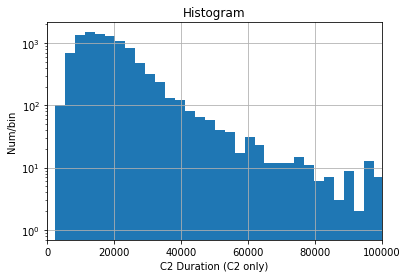

In [13]:
plot_hist(c2_data['Duration_C2'], what='C2 Duration (C2 only)', ylog=True, xhigh=100000)

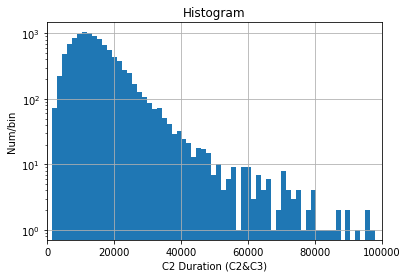

In [14]:
plot_hist(c2_c3_data['Duration_C2'], what='C2 Duration (C2&C3)', ylog=True, xhigh=100000)

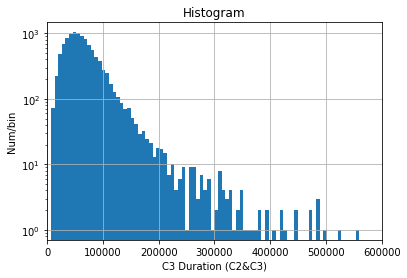

In [15]:
plot_hist(c2_c3_data['Duration_C3'], what='C3 Duration (C2&C3)', ylog=True, xhigh=600000)

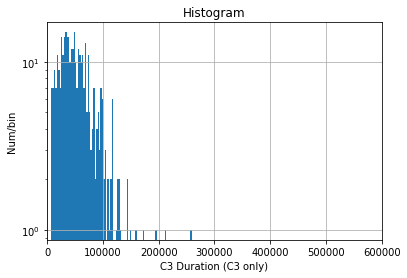

In [16]:
plot_hist(c3_data['Duration_C3'], what='C3 Duration (C3 only)', ylog=True, xhigh=600000)

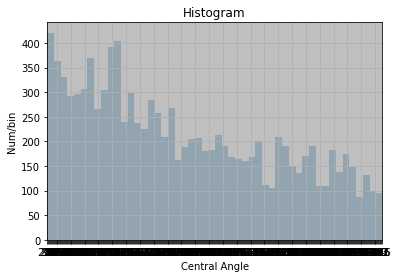

In [17]:
plot_hist(c2_c3_data['Central'], nbins=50, what='Central Angle', ylog=False, xhigh=359)

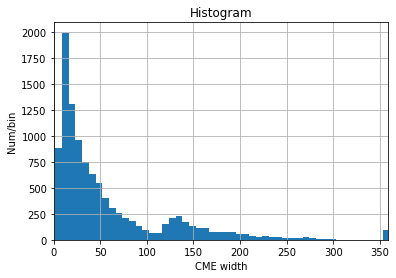

In [18]:
plot_hist(pd.to_numeric(c2_c3_data['Width']), nbins=50, what='CME width', ylog=False, xhigh=359)

In [19]:
c2_c3_data

,Date,Time,Central,Width,Linear,2nd,order,speed,Accel,Mass,...,Remarks,Duration_C2,Duration_C3,StartTime_C3_Delta,width,linear,mpa,mass,kinetic,accel
5,1996/01/31,06:52:13,274,47,158,219,99,0,-12.3*,2.5e+14*,...,Poor Event; Only 3 points\n,26582.278481,116518.987342,9746.835443,47,158,272,2.500000e+14,3.200000e+28,-12.3
8,1996/02/12,05:47:26,91,53,160,100,211,236,2.0*,1.3e+15,...,Poor Event\n,26250.000000,115062.500000,9625.000000,53,160,92,1.300000e+15,1.600000e+29,2.0
9,1996/02/17,02:06:31,279,73,317,257,378,532,9.9*,3.3e+14*,...,Very Poor Event\n,13249.211356,58075.709779,4858.044164,73,317,274,3.300000e+14,1.600000e+29,9.9
12,1996/03/02,04:11:53,88,36,108,95,120,177,1.0*,1.5e+14,...,Poor Event\n,38888.888889,170462.962963,14259.259259,36,108,86,1.500000e+14,8.700000e+27,1.0
16,1996/03/07,07:51:56,91,43,60,60,61,75,0.1*,-------,...,Poor Event\n,70000.000000,306833.333333,25666.666667,43,60,87,0.000000e+00,0.000000e+00,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30478,2020/08/29,00:00:05,86,16,281,220,339,478,8.4*,-------,...,Poor Event\n,14946.619217,65516.014235,5480.427046,16,281,89,0.000000e+00,0.000000e+00,8.4
30480,2020/08/29,15:36:05,284,11,196,227,163,0,-4.8*,-------,...,Poor Event\n,21428.571429,93928.571429,7857.142857,11,196,282,0.000000e+00,0.000000e+00,-4.8
30481,2020/08/29,19:48:05,285,10,218,231,204,79,-2.0*,-------,...,Poor Event\n,19266.055046,84449.541284,7064.220183,10,218,272,0.000000e+00,0.000000e+00,-2.0
30482,2020/08/30,01:25:44,258,42,117,0,213,286,3.5*,-------,...,Poor Event\n,35897.435897,157350.427350,13162.393162,42,117,250,0.000000e+00,0.000000e+00,3.5


In [20]:
# persist dataset
c2_c3_data.to_csv(CME_Catalog_Filename, index=False)

In [21]:
len(c2_c3_data)

10696

In [ ]:
c2_c3_data